In [23]:
import torch
from torch_geometric.data import Data
import pandas as pd
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import StandardScaler
from torch.optim import Adam
from torch.nn import MSELoss, L1Loss
import matplotlib.pyplot as plt
import Models.GNNs.util as util

In [24]:
df = pd.read_csv('Datasets/Lynx_Hare/data.csv', usecols=['DATE', 'HARE', 'LYNX'])
species = ['HARE', 'LYNX']

# Create lagged features for one-step ahead prediction
df['HARE_lag1'] = df['HARE'].shift(1)
df['LYNX_lag1'] = df['LYNX'].shift(1)

df.dropna(inplace=True)

# Define features (x) and targets (y)
x = df[['HARE_lag1', 'LYNX_lag1']].values  # previous time step's data as input
y = df[['HARE', 'LYNX']].values

In [25]:
# Sequential split for training and testing
split_idx = int(len(x) * 0.8)
x_train, x_test = x[:split_idx], x[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

# Convert to PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.float)
x_test = torch.tensor(x_test, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.float)
y_test = torch.tensor(y_test, dtype=torch.float)

In [26]:
edge_index = torch.tensor([[0], [1]], dtype=torch.long)  # Lynx -> Hare

data_train = Data(x=x_train, edge_index=edge_index)
data_test = Data(x=x_test, edge_index=edge_index)

In [27]:
# Model Implementation
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(2, 16)
        self.conv2 = GCNConv(16, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = torch.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

In [28]:
model = GNN()
optimizer = Adam(model.parameters(), lr=0.01)
criterion = MSELoss()
mae_criterion = L1Loss()

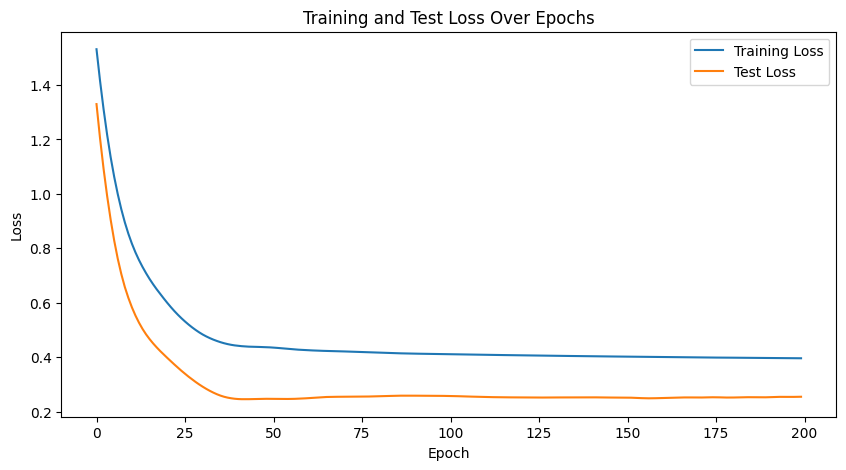

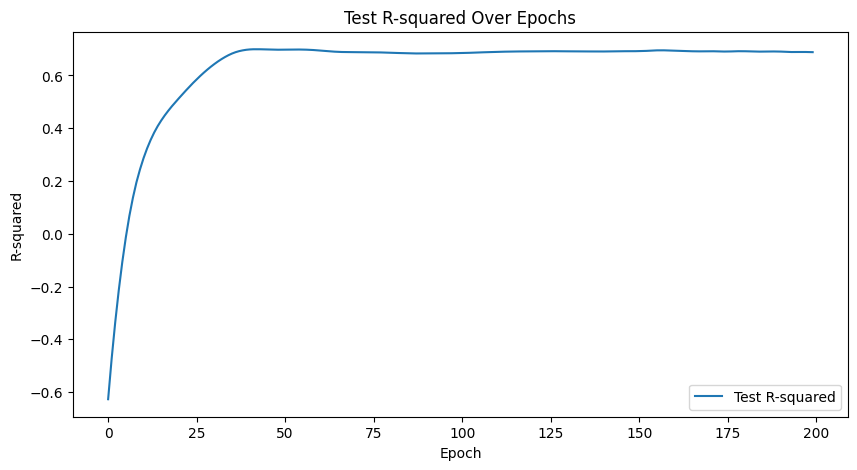

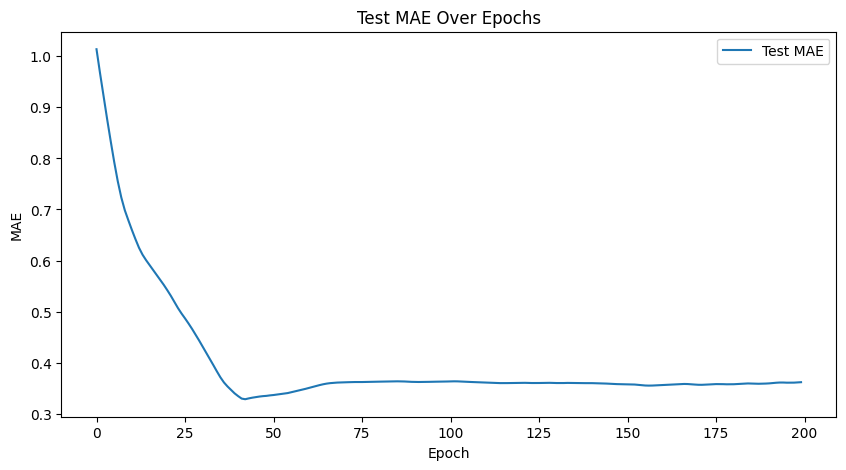

Final Test MSE: 0.2546984851360321
Final Test R-squared: 0.6883866190910339
Final Test MAE: 0.3617073595523834


In [29]:
train_losses = []
test_losses = []
r2_losses = []
mae_losses = []


for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data_train)
    train_loss = criterion(out, y_train)
    train_loss.backward()
    optimizer.step()
    
    model.eval()  
    with torch.no_grad(): # gradient is not computed
        test_pred = model(data_test)
        test_loss = criterion(test_pred, y_test)
        r2 = util.r_squared(y_test, test_pred) 
        mae_loss = mae_criterion(test_pred, y_test)

    
    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())
    r2_losses.append(r2.item())
    mae_losses.append(mae_loss.item())

# training and testing losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.show()

# Plot R-squared values
plt.figure(figsize=(10, 5))
plt.plot(r2_losses, label='Test R-squared')
plt.xlabel('Epoch')
plt.ylabel('R-squared')
plt.title('Test R-squared Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(mae_losses, label='Test MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Test MAE Over Epochs')
plt.legend()
plt.show()

model.eval() 
with torch.no_grad(): 
    final_pred = model(data_test)
    final_mse_test = criterion(final_pred, y_test)
    final_r2_test = util.r_squared(y_test, final_pred)
    final_mae_test = mae_criterion(final_pred, y_test)

print(f'Final Test MSE: {final_mse_test.item()}')
print(f'Final Test R-squared: {final_r2_test.item()}')
print(f'Final Test MAE: {final_mae_test.item()}')

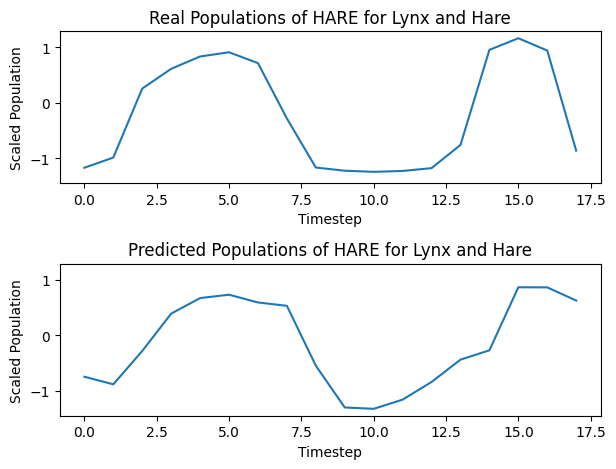

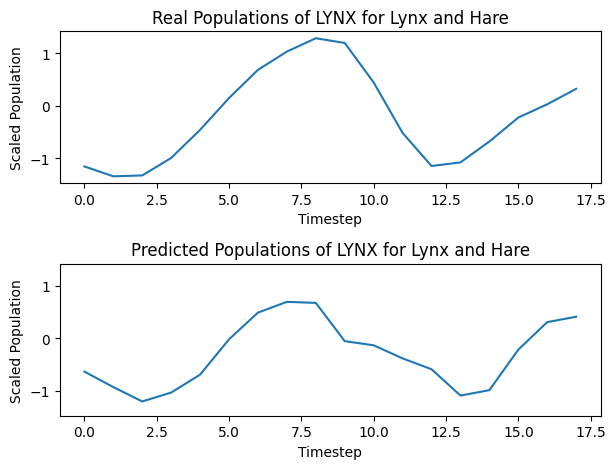

In [30]:
df = pd.read_csv('Datasets/Lynx_Hare/data.csv', usecols=['DATE', 'HARE', 'LYNX'])
species = ['HARE', 'LYNX']
dataset_name = 'Lynx and Hare'

# Create lagged features for one-step ahead prediction
df['HARE_lag1'] = df['HARE'].shift(1)
df['LYNX_lag1'] = df['LYNX'].shift(1)

df.dropna(inplace=True)

# Define features (x) and targets (y)
x = df[['HARE_lag1', 'LYNX_lag1']].values  # previous time step's data as input
y = df[['HARE', 'LYNX']].values

# Sequential split for training and testing
split_idx = int(len(x) * 0.8)
x_train, x_test = x[:split_idx], x[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

# Convert to PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.float)
x_test = torch.tensor(x_test, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.float)
y_test = torch.tensor(y_test, dtype=torch.float)

edge_index = torch.tensor([[0], [1]], dtype=torch.long)  # Lynx -> Hare

data_train = Data(x=x_train, edge_index=edge_index)
data_test = Data(x=x_test, edge_index=edge_index)

y_test_pred = model(data_test).detach().numpy()

for expected, predicted, s  in zip(y_test.T, y_test_pred.T, species):
    _, (real, pred) = plt.subplots(2, sharey = True)
    pred.plot(range(len(predicted)), predicted)
    pred.title.set_text(f'Predicted Populations of {s} for {dataset_name}')
    pred.set_xlabel('Timestep')
    pred.set_ylabel('Scaled Population')
    real.plot(range(len(predicted)), expected)
    real.title.set_text(f'Real Populations of {s} for {dataset_name}')
    real.set_xlabel('Timestep')
    real.set_ylabel('Scaled Population')
    plt.tight_layout()
    plt.show()

In [31]:
df = pd.read_csv('Datasets/study_373/top_5_373_time.csv', usecols=['46670', '46982', '46504', '46571', '46888'])
"""
46670  [Nyctereutes procyonoides]     Common Raccoon Dog      -> Rodents, Japanese Hare
46982  [Sus scrofa]				      Wild Boar               -> Rodents, Japanese Hare
46504  [Lepus brachyurus]			  Japanese Hare
46571  [Meles anakuma]			      Japanese Badger         -> Rodents
46888  [Rodentia]
"""

for col in ['46670', '46982', '46504', '46571', '46888']:
    df[f'{col}_lag1'] = df[col].shift(1)
df.dropna(inplace=True)

# Define features (x) and targets (y)
x = df[['46670_lag1', '46982_lag1', '46504_lag1', '46571_lag1', '46888_lag1']].values  # previous time step's data as input
y = df[['46670', '46982', '46504', '46571', '46888']].values

In [32]:
# Sequential split for training and testing
split_idx = int(len(x) * 0.8)
x_train, x_test = x[:split_idx], x[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

# Convert to PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.float)
x_test = torch.tensor(x_test, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.float)
y_test = torch.tensor(y_test, dtype=torch.float)

In [33]:
edge_index = torch.tensor([
    [0, 0, 3, 3, 4],  # Predators: 46670 (Index 0), 46982 (Index 3), 46571 (Index 4)
    [1, 2, 1, 2, 1]   # Prey: 46888 (Index 1), 46504 (Index 2)
], dtype=torch.long)
data_train = Data(x=x_train, edge_index=edge_index)
data_test = Data(x=x_test, edge_index=edge_index)

In [34]:
# Model Implementation
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(5, 16)
        self.conv2 = GCNConv(16, 5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = torch.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

In [35]:
model = GNN()
optimizer = Adam(model.parameters(), lr=0.01)
criterion = MSELoss()
mae_criterion = L1Loss()

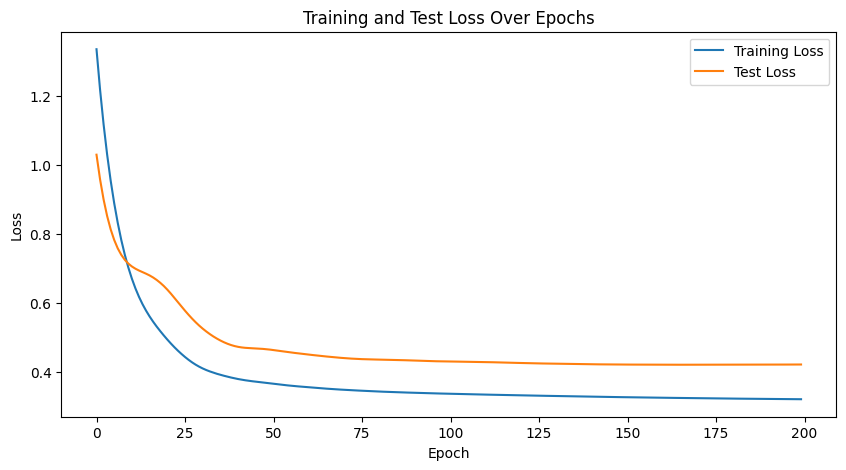

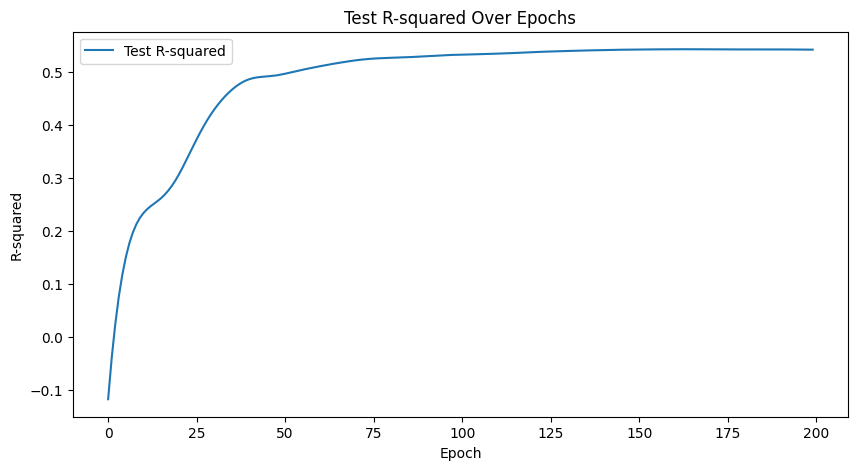

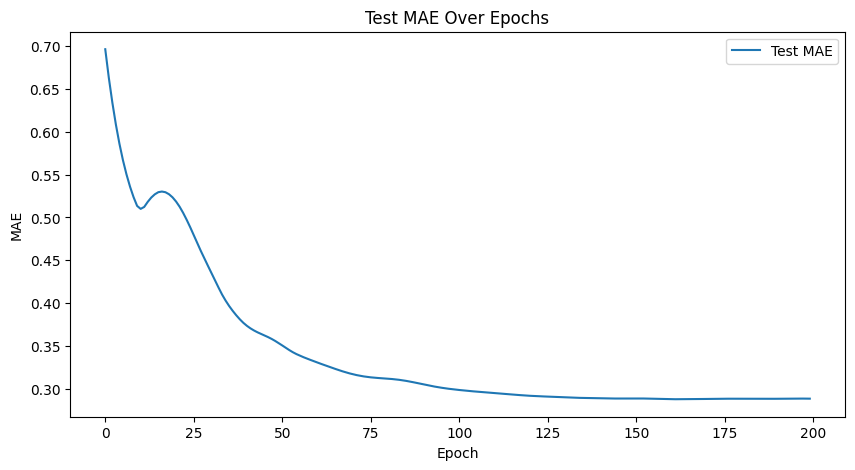

Final Test MSE: 0.42257580161094666
Final Test R-squared: 0.5411614179611206
Final Test MAE: 0.28828054666519165


In [36]:
train_losses = []
test_losses = []
r2_losses = []
mae_losses = []


for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data_train)
    train_loss = criterion(out, y_train)
    train_loss.backward()
    optimizer.step()
    
    model.eval()  
    with torch.no_grad(): # gradient is not computed
        test_pred = model(data_test)
        test_loss = criterion(test_pred, y_test)
        r2 = util.r_squared(y_test, test_pred) 
        mae_loss = mae_criterion(test_pred, y_test)

    
    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())
    r2_losses.append(r2.item())
    mae_losses.append(mae_loss.item())

# training and testing losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.show()

# Plot R-squared values
plt.figure(figsize=(10, 5))
plt.plot(r2_losses, label='Test R-squared')
plt.xlabel('Epoch')
plt.ylabel('R-squared')
plt.title('Test R-squared Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(mae_losses, label='Test MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Test MAE Over Epochs')
plt.legend()
plt.show()

model.eval() 
with torch.no_grad(): 
    final_pred = model(data_test)
    final_mse_test = criterion(final_pred, y_test)
    final_r2_test = util.r_squared(y_test, final_pred)
    final_mae_test = mae_criterion(final_pred, y_test)

print(f'Final Test MSE: {final_mse_test.item()}')
print(f'Final Test R-squared: {final_r2_test.item()}')
print(f'Final Test MAE: {final_mae_test.item()}')

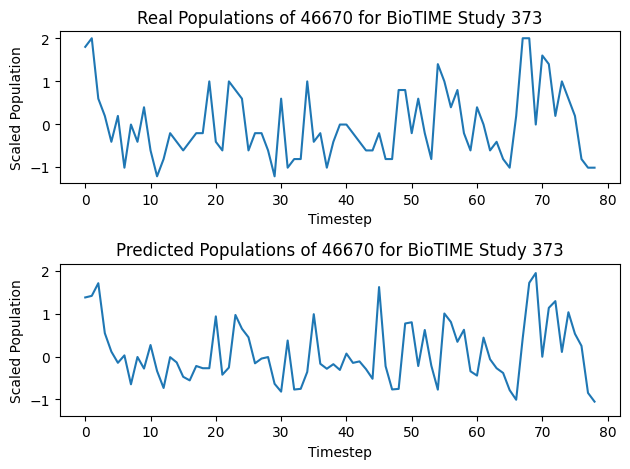

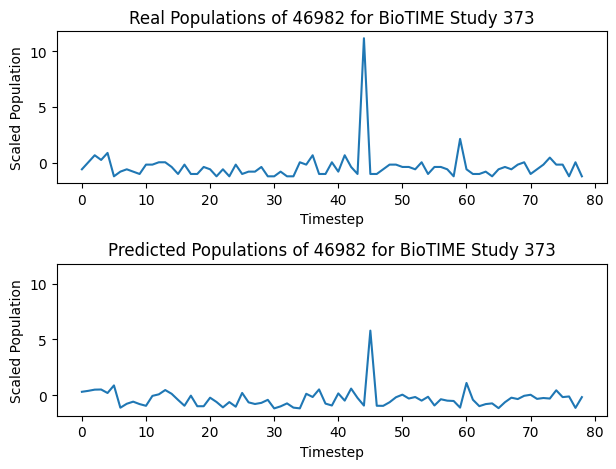

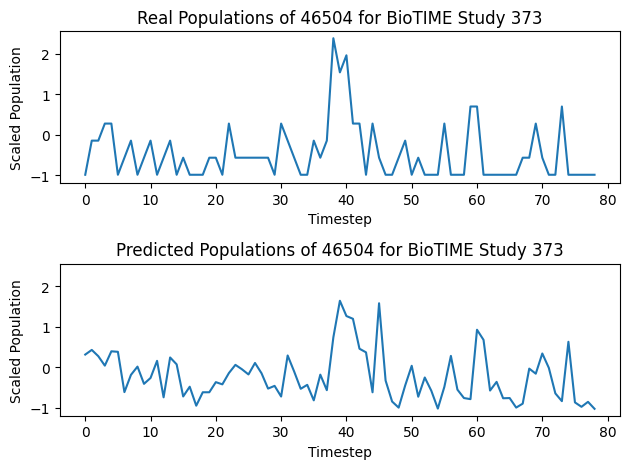

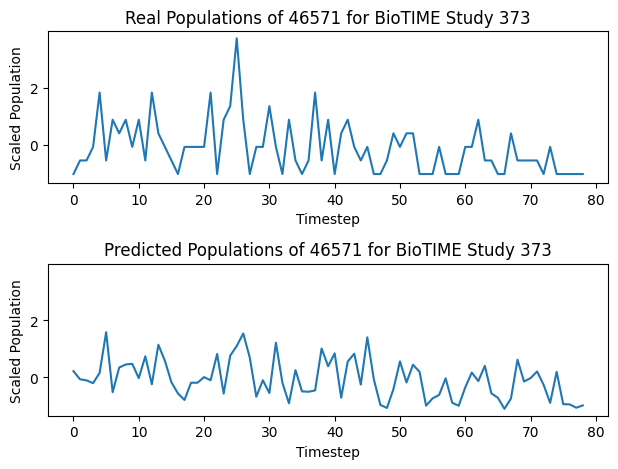

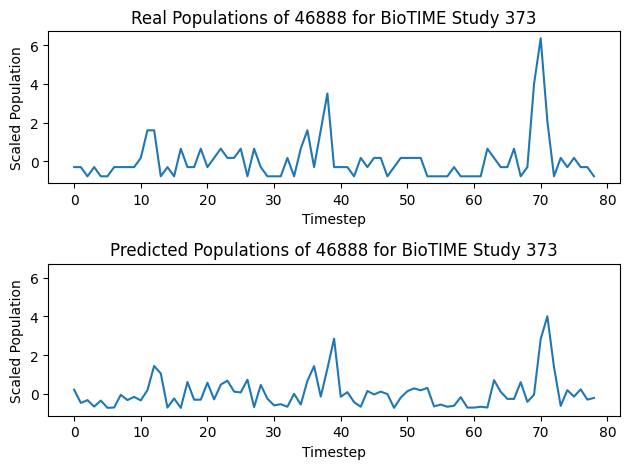

In [37]:
df = pd.read_csv('Datasets/study_373/top_5_373.csv', usecols=['46670', '46982', '46504', '46571', '46888'])
"""
46670  [Nyctereutes procyonoides]     Common Raccoon Dog      -> Rodents, Japanese Hare
46982  [Sus scrofa]				      Wild Boar               -> Rodents, Japanese Hare
46504  [Lepus brachyurus]			  Japanese Hare
46571  [Meles anakuma]			      Japanese Badger         -> Rodents
46888  [Rodentia]
"""
dataset_name = 'BioTIME Study 373'
species = ['46670', '46982', '46504', '46571', '46888']

for col in ['46670', '46982', '46504', '46571', '46888']:
    df[f'{col}_lag1'] = df[col].shift(1)
df.dropna(inplace=True)

# Define features (x) and targets (y)
x = df[['46670_lag1', '46982_lag1', '46504_lag1', '46571_lag1', '46888_lag1']].values  # previous time step's data as input
y = df[['46670', '46982', '46504', '46571', '46888']].values

# Sequential split for training and testing
split_idx = int(len(x) * 0.8)
x_train, x_test = x[:split_idx], x[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

# Convert to PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.float)
x_test = torch.tensor(x_test, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.float)
y_test = torch.tensor(y_test, dtype=torch.float)

edge_index = torch.tensor([
    [0, 0, 3, 3, 4],  # Predators: 46670 (Index 0), 46982 (Index 3), 46571 (Index 4)
    [1, 2, 1, 2, 1]   # Prey: 46888 (Index 1), 46504 (Index 2)
], dtype=torch.long)
data_train = Data(x=x_train, edge_index=edge_index)
data_test = Data(x=x_test, edge_index=edge_index)

y_test_pred = model(data_test).detach().numpy()

for expected, predicted, s  in zip(y_test.T, y_test_pred.T, species):
    _, (real, pred) = plt.subplots(2, sharey = True)
    pred.plot(range(len(predicted)), predicted)
    pred.title.set_text(f'Predicted Populations of {s} for {dataset_name}')
    pred.set_xlabel('Timestep')
    pred.set_ylabel('Scaled Population')
    real.plot(range(len(predicted)), expected)
    real.title.set_text(f'Real Populations of {s} for {dataset_name}')
    real.set_xlabel('Timestep')
    real.set_ylabel('Scaled Population')
    plt.tight_layout()
    plt.show()

In [38]:
df = pd.read_csv('Datasets/study_213/top_5_213_time.csv', usecols=['7058', '8572', '39601', '8901', '7730'])
"""
7058 ['Merluccius bilinearis']  Silver hake             -> Silver hake, Spiny dogfish, Longfin inshore squid, Red hake, American butterfish
8572 ['Squalus acanthias']      Spiny dogfish           -> Silver hake, Spiny dogfish, Longfin inshore squid, Red hake, American butterfish
39601 ['Doryteuthis pealeii']   Longfin inshore squid   -> Silver hake, Longfin inshore squid
8901 ['Urophycis chuss']        Red hake                -> Silver hake, Longfin inshore squid, Red hake, American butterfish
7730 ['Peprilus triacanthus']   American butterfish     -> Longfin inshore squid
"""

for col in ['7058', '8572', '39601', '8901', '7730']:
    df[f'{col}_lag1'] = df[col].shift(1)
df.dropna(inplace=True)

# Define features (x) and targets (y)
x = df[['7058_lag1', '8572_lag1', '39601_lag1', '8901_lag1', '7730_lag1']].values  # previous time step's data as input
y = df[['7058', '8572', '39601', '8901', '7730']].values

In [39]:
# Sequential split for training and testing
split_idx = int(len(x) * 0.8)
x_train, x_test = x[:split_idx], x[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

# Convert to PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.float)
x_test = torch.tensor(x_test, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.float)
y_test = torch.tensor(y_test, dtype=torch.float)

In [40]:
edge_index = torch.tensor([
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 4],  
    [0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 2, 0, 2, 3, 4, 2]   
], dtype=torch.long)
data_train = Data(x=x_train, edge_index=edge_index)
data_test = Data(x=x_test, edge_index=edge_index)

In [41]:
# Model Implementation
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(5, 16)
        self.conv2 = GCNConv(16, 5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = torch.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

In [42]:
model = GNN()
optimizer = Adam(model.parameters(), lr=0.01)
criterion = MSELoss()
criterion_mae = L1Loss()

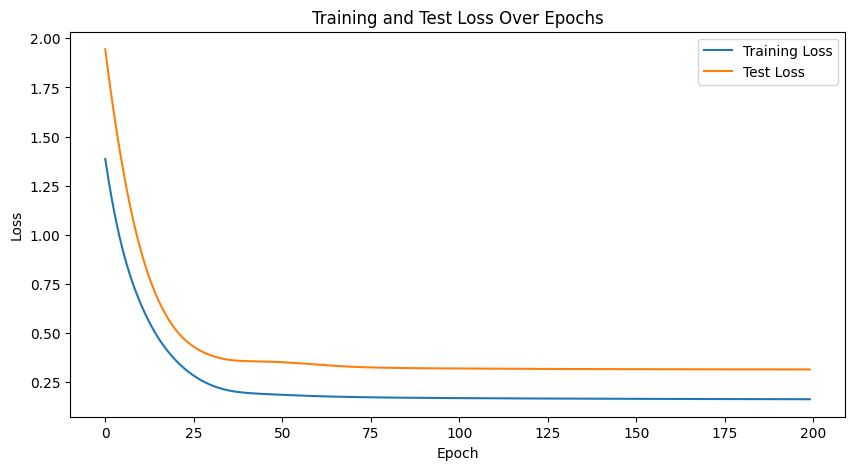

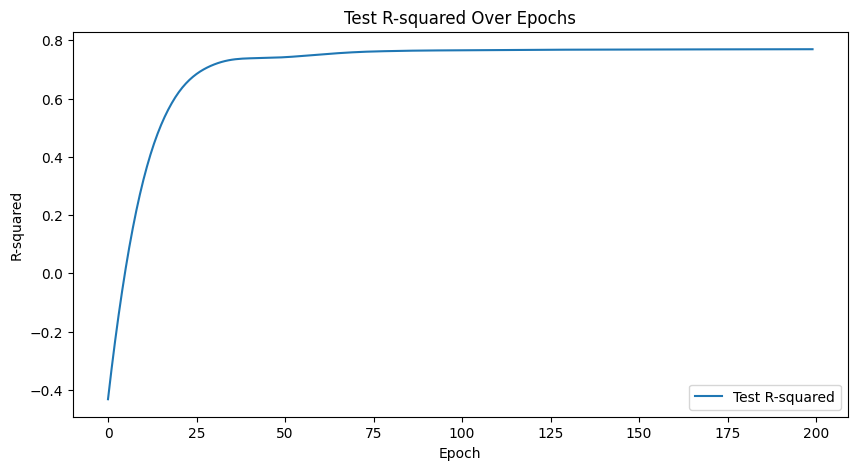

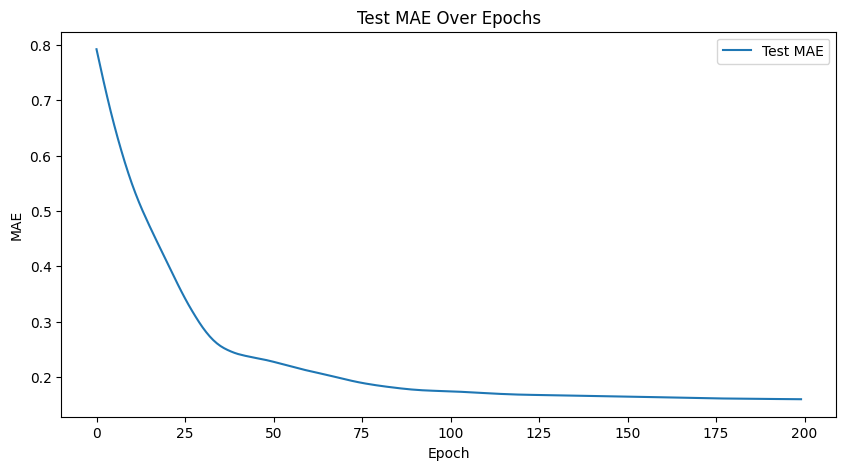

Final Test MSE: 0.31323254108428955
Final Test R-squared: 0.7693032622337341
Final Test MAE: 0.15987485647201538


In [43]:
train_losses = []
test_losses = []
r2_losses = []
mae_losses = []


for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data_train)
    train_loss = criterion(out, y_train)
    train_loss.backward()
    optimizer.step()
    
    model.eval()  
    with torch.no_grad(): # gradient is not computed
        test_pred = model(data_test)
        test_loss = criterion(test_pred, y_test)
        r2 = util.r_squared(y_test, test_pred) 
        mae_loss = mae_criterion(test_pred, y_test)

    
    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())
    r2_losses.append(r2.item())
    mae_losses.append(mae_loss.item())

# training and testing losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.show()

# Plot R-squared values
plt.figure(figsize=(10, 5))
plt.plot(r2_losses, label='Test R-squared')
plt.xlabel('Epoch')
plt.ylabel('R-squared')
plt.title('Test R-squared Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(mae_losses, label='Test MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Test MAE Over Epochs')
plt.legend()
plt.show()

model.eval() 
with torch.no_grad(): 
    final_pred = model(data_test)
    final_mse_test = criterion(final_pred, y_test)
    final_r2_test = util.r_squared(y_test, final_pred)
    final_mae_test = mae_criterion(final_pred, y_test)

print(f'Final Test MSE: {final_mse_test.item()}')
print(f'Final Test R-squared: {final_r2_test.item()}')
print(f'Final Test MAE: {final_mae_test.item()}')

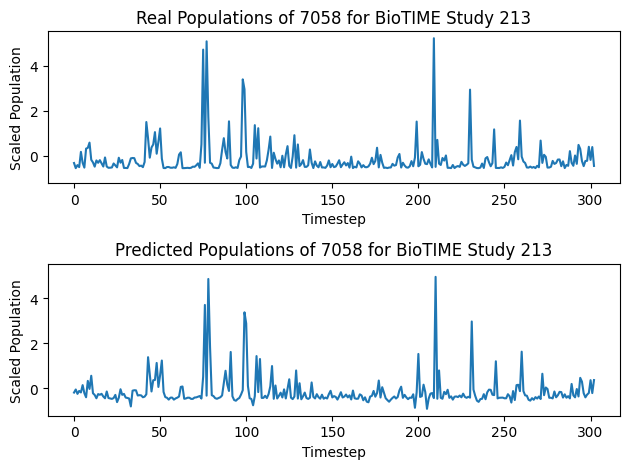

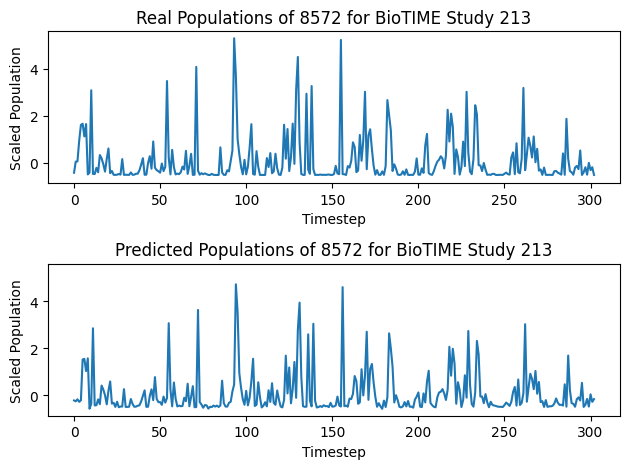

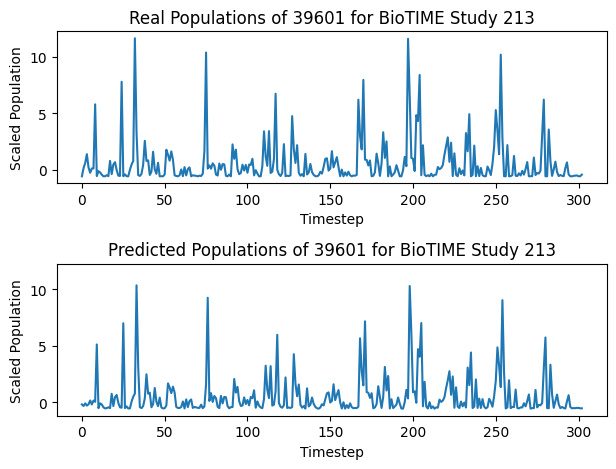

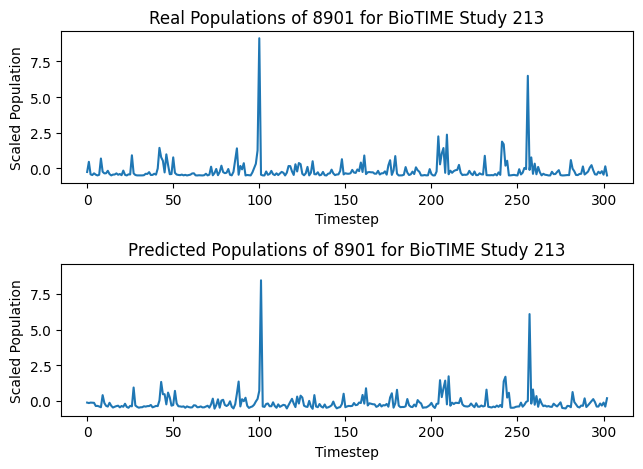

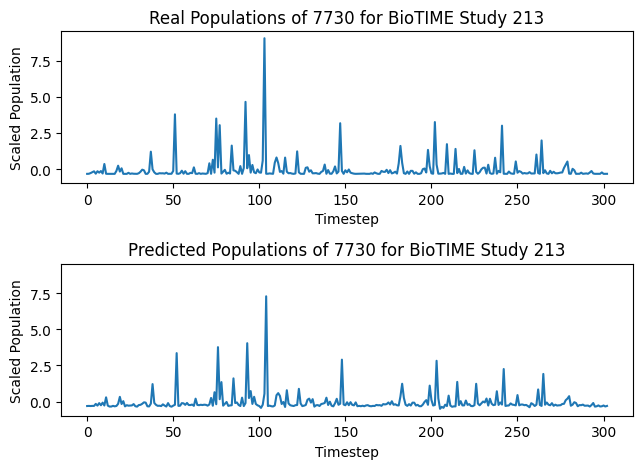

In [44]:
df = pd.read_csv('Datasets/study_213/top_5_213.csv', usecols=['7058', '8572', '39601', '8901', '7730'])
"""
7058 ['Merluccius bilinearis']  Silver hake             -> Silver hake, Spiny dogfish, Longfin inshore squid, Red hake, American butterfish
8572 ['Squalus acanthias']      Spiny dogfish           -> Silver hake, Spiny dogfish, Longfin inshore squid, Red hake, American butterfish
39601 ['Doryteuthis pealeii']   Longfin inshore squid   -> Silver hake, Longfin inshore squid
8901 ['Urophycis chuss']        Red hake                -> Silver hake, Longfin inshore squid, Red hake, American butterfish
7730 ['Peprilus triacanthus']   American butterfish     -> Longfin inshore squid
"""

dataset_name = 'BioTIME Study 213'
species = ['7058', '8572', '39601', '8901', '7730']

for col in ['7058', '8572', '39601', '8901', '7730']:
    df[f'{col}_lag1'] = df[col].shift(1)
df.dropna(inplace=True)

# Define features (x) and targets (y)
x = df[['7058_lag1', '8572_lag1', '39601_lag1', '8901_lag1', '7730_lag1']].values  # previous time step's data as input
y = df[['7058', '8572', '39601', '8901', '7730']].values

# Sequential split for training and testing
split_idx = int(len(x) * 0.8)
x_train, x_test = x[:split_idx], x[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

# Convert to PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.float)
x_test = torch.tensor(x_test, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.float)
y_test = torch.tensor(y_test, dtype=torch.float)

edge_index = torch.tensor([
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 4],  
    [0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 2, 0, 2, 3, 4, 2]   
], dtype=torch.long)
data_train = Data(x=x_train, edge_index=edge_index)
data_test = Data(x=x_test, edge_index=edge_index)

y_test_pred = model(data_test).detach().numpy()

for expected, predicted, s  in zip(y_test.T, y_test_pred.T, species):
    _, (real, pred) = plt.subplots(2, sharey = True)
    pred.plot(range(len(predicted)), predicted)
    pred.title.set_text(f'Predicted Populations of {s} for {dataset_name}')
    pred.set_xlabel('Timestep')
    pred.set_ylabel('Scaled Population')
    real.plot(range(len(predicted)), expected)
    real.title.set_text(f'Real Populations of {s} for {dataset_name}')
    real.set_xlabel('Timestep')
    real.set_ylabel('Scaled Population')
    plt.tight_layout()
    plt.show()